In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = torch.tensor(pd.read_csv("data.txt", header=None).values)
data.shape

torch.Size([10000, 1])

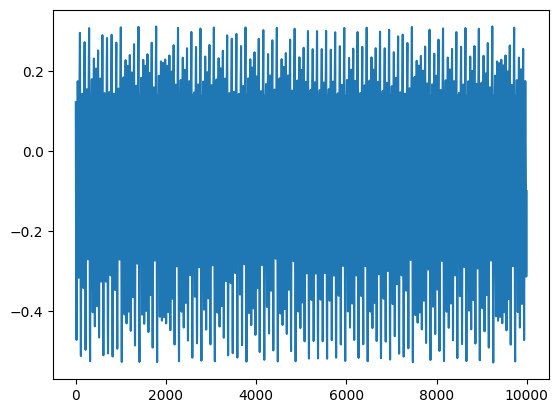

In [3]:
plt.plot(data)

In [4]:
CONTEXT_LENGTH = 1
EPOCHS = 50
LEARNING_RATE = 3e-4
BATCH_SIZE = 16
HIDDEN_SIZE = 32

In [5]:
data[len(data) - 10::]

tensor([[-0.3137],
        [-0.3097],
        [-0.2974],
        [-0.2785],
        [-0.2549],
        [-0.2285],
        [-0.2002],
        [-0.1701],
        [-0.1373],
        [-0.1003]], dtype=torch.float64)

In [6]:
arr = [data[i:i+CONTEXT_LENGTH] for i in range(len(data) - CONTEXT_LENGTH)]
x = torch.hstack(arr).transpose(0, 1)
y = torch.tensor(data[CONTEXT_LENGTH:len(data)], requires_grad=True)
x.shape, y.shape

C:\Users\adika\AppData\Local\Temp\ipykernel_4964\1857358162.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(data[CONTEXT_LENGTH:len(data)], requires_grad=True)


(torch.Size([9999, 1]), torch.Size([9999, 1]))

In [7]:
x[-1], y[-1]

(tensor([-0.1373], dtype=torch.float64),
 tensor([-0.1003], dtype=torch.float64, grad_fn=<SelectBackward0>))

In [8]:
x[0], y[0]

(tensor([0.1221], dtype=torch.float64),
 tensor([0.0472], dtype=torch.float64, grad_fn=<SelectBackward0>))

In [9]:
size = int(0.8 * x.shape[0])
X_train = x[:size]
y_train = y[:size]

X_test = x[size:]
y_test = y[size:]

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([7999, 1]),
 torch.Size([7999, 1]),
 torch.Size([2000, 1]),
 torch.Size([2000, 1]))

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = DataLoader(TimeSeriesDataset(X_train, y_train), BATCH_SIZE, shuffle=True)
test_dataset = DataLoader(TimeSeriesDataset(X_test, y_test), BATCH_SIZE, shuffle=True)

In [12]:
train_dataset = DataLoader(TimeSeriesDataset(X_train, y_train), BATCH_SIZE, shuffle=True)
test_dataset = DataLoader(TimeSeriesDataset(X_test, y_test), BATCH_SIZE, shuffle=True)

In [13]:
c = 0
for i in train_dataset:
    x, y = i
    print(x.shape)
    print(y.shape)
    c += 1

c

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])


500

In [26]:
class RNN(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.rnn = nn.RNN(CONTEXT_LENGTH, hidden_size)
    self.out = nn.Linear(hidden_size, 1)
  
  def forward(self, x):
    x = self.rnn(x)[0]
    x = self.out(x)
    return x


class RealRNN(nn.Module):
  def __init__(self, in_dim, hidden_size):
    super().__init__()
    self.rnn = RNN(hidden_size)
  
  def forward(self, x):
    return self.rnn(x)

In [160]:
class MyRNNCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.Wxh = nn.Linear(in_dim, hidden_dim)
        self.Whh = nn.Linear(hidden_dim, hidden_dim)
        self.Who = nn.Linear(hidden_dim, out_dim)

    def forward(self, xt, ht):
        xh = self.Wxh(xt)
        hidden_state = self.Whh(ht)
        hidden_state = F.tanh(hidden_state + xh)
        output = self.Who(hidden_state)
        return (hidden_state, output)


class MyRNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cell = MyRNNCell(in_dim, hidden_dim)
    
    def forward(self, x):
        ht = torch.zeros((self.hidden_dim,))
        res = []
        for t in range(x.shape[0]):
            ht, output = self.cell(x[t], ht)
            res.append(output)
        
        return torch.tensor(res, requires_grad=True)

In [161]:
def train_epoch(model, optim):
    lossi = []
    for x, y in train_dataset:
        output = model(x.float())
        loss = F.mse_loss(output, y.float())

        optim.zero_grad()
        loss.backward()
        optim.step()

        lossi.append(loss.item())
    
    return torch.tensor(lossi).mean().item()


@torch.no_grad()
def val_epoch(model):
    lossi = []
    for x, y in test_dataset:
        output = model(x.float())
        loss = F.mse_loss(output, y.float())
        lossi.append(loss.item())
    
    return torch.tensor(lossi).mean().item()

In [162]:
# model = RealRNN(CONTEXT_LENGTH, HIDDEN_SIZE)
# optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)

# for name,i in model.named_parameters():
#     print(name, ": ", i.shape, i.grad)

In [163]:
model = MyRNN(CONTEXT_LENGTH, HIDDEN_SIZE)
optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)

for name, i in model.named_parameters():
    print(name, ": ", i.shape, i.grad)

cell.Wxh.weight :  torch.Size([32, 1]) None
cell.Wxh.bias :  torch.Size([32]) None
cell.Whh.weight :  torch.Size([32, 32]) None
cell.Whh.bias :  torch.Size([32]) None
cell.Who.weight :  torch.Size([1, 32]) None
cell.Who.bias :  torch.Size([1]) None


In [164]:
# model = RNN(HIDDEN_SIZE)
# model = MyRNN(CONTEXT_LENGTH, HIDDEN_SIZE)
# model = RealRNN(HIDDEN_SIZE)

for batch in train_dataset:
    x, y = batch
    output = model(x.float())
    loss = F.mse_loss(output, y.float().squeeze(1))
    loss.backward()
    
    for name,i in model.named_parameters():
        print(name, ": ", i.shape, i.grad)
    break

cell.Wxh.weight :  torch.Size([32, 1]) None
cell.Wxh.bias :  torch.Size([32]) None
cell.Whh.weight :  torch.Size([32, 32]) None
cell.Whh.bias :  torch.Size([32]) None
cell.Who.weight :  torch.Size([1, 32]) None
cell.Who.bias :  torch.Size([1]) None


In [165]:
train_lossi = []
test_lossi = []
for epoch in range(EPOCHS):
  train_loss = train_epoch(model, optim)
  test_loss = val_epoch(model)

  train_lossi.append(train_loss)
  test_lossi.append(test_loss)

  print(f"EPOCH: {epoch} |  TRAIN-LOSS: {train_loss} |  VAL-LOSS: {test_loss}")

C:\Users\adika\AppData\Local\Temp\ipykernel_4964\320147985.py:5: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, y.float())
C:\Users\adika\AppData\Local\Temp\ipykernel_4964\320147985.py:5: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, y.float())
C:\Users\adika\AppData\Local\Temp\ipykernel_4964\320147985.py:21: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, y.float())


EPOCH: 0 |  TRAIN-LOSS: 0.23777493834495544 |  VAL-LOSS: 0.23759105801582336
EPOCH: 1 |  TRAIN-LOSS: 0.2377082258462906 |  VAL-LOSS: 0.2376859486103058
EPOCH: 2 |  TRAIN-LOSS: 0.23792649805545807 |  VAL-LOSS: 0.23732390999794006
EPOCH: 3 |  TRAIN-LOSS: 0.2377167046070099 |  VAL-LOSS: 0.23776042461395264


KeyboardInterrupt: 

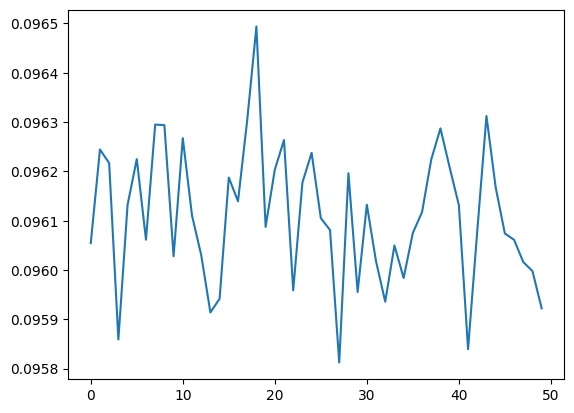

In [47]:
plt.plot(train_lossi)

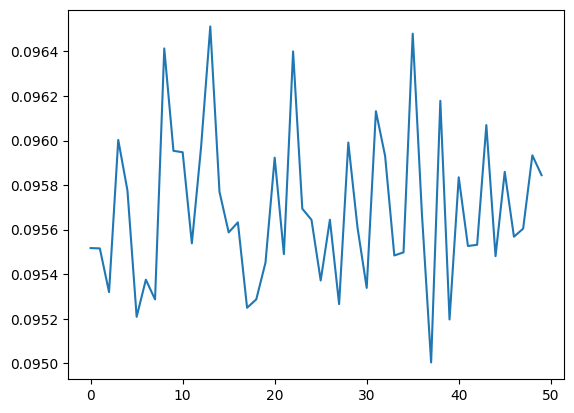

In [48]:
plt.plot(test_lossi)

C:\Users\adika\AppData\Local\Temp\ipykernel_4964\969098012.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(res)


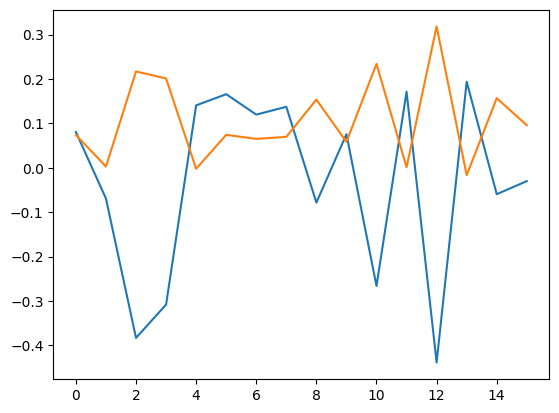

In [49]:
for i in test_dataset:
    x, y = i
    output = model(x.float())

    plt.plot(y.detach().numpy())
    plt.plot(output.detach().numpy())
    break